### Load the Libraries

In [1]:
from Bio import SeqIO
import Bio
import re
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches

In [17]:
print(f'BioPython v{Bio.__version__}')
print(f're module v{re.__version__}')
print(f'matplotlib v{matplotlib.__version__}')
print(f'pandas v{pd.__version__}')

BioPython v1.79
re module v2.2.1
matplotlib v3.4.2
pandas v1.3.3


In [3]:
!python --version

Python 3.8.12


In [4]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.27.0
ipykernel        : 6.4.1
ipywidgets       : 7.6.5
jupyter_client   : 7.0.1
jupyter_core     : 4.8.1
jupyter_server   : 1.4.1
jupyterlab       : 3.1.7
nbclient         : 0.5.3
nbconvert        : 6.1.0
nbformat         : 5.1.3
notebook         : 6.4.3
qtconsole        : 5.1.1
traitlets        : 5.1.0


### About GenBank files and how to deal with them

We are dealing with .gb/.gbk files with single records each.

From (https://warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/genbank/)-

    Depending on the type of GenBank file(s) you are interested in, they will either contain a single record, or multiple records. You can easily determine this by looking at the raw file - each record will start with a LOCUS line, followed by various other header lines, usually a list of features, the sequence data, and ends with a // line (slash slash).

Locations provided by **BioPython** is optimum for python purposes.
- start and end provided by it are 1938 and 3075 respectively (0-based indexing and it assumes that end position is not included),
- while in our actual file it is 1939 and 3075 (1-based indexing and it assumes that both start and end positions are included).

This way we can directly slice seq string using locations provided to obtain the seq for the features of our interest.

1. **The DDBJ/ENA/GenBank Feature Table Definition**: 
    Documentation of features in genbank files. Very good document, must go-through this once.
    
    Source:
    - (https://www.insdc.org/documents/feature_table.html)



2. **Locus tag:**
    Locus_tags are identifiers that are systematically applied to every gene in a genome.
    These tags have become surrogate gene names by the biological community. If two
    submitters of two different genomes use the same systematic names to describe two very
    different genes in two very different genomes, it can be very confusing. In order to
    prevent this from happening INSD has created a registry of locus_tag prefixes.
    Submitters of eukaryotic and prokaryotic genomes should register their prefix prior to
    submitting their genome. All components of a project (such as multiple chromosomes or
    plasmids, etc) should use the same locus_tag prefix. 
    
    Source:
    - (https://www.ncbi.nlm.nih.gov/genomes/locustag/Proposal.pdf)
    - (https://www.ncbi.nlm.nih.gov/genbank/genomesubmit_annotation/#locus_tag)

### Extracting desirable information

Useful videos for the analysis done later-
1. https://www.youtube.com/watch?v=LdQV3cbUwEE&list=PLe1-kjuYBZ05T9iHV_z60B9mpFt201ND5&index=8
2. https://www.youtube.com/watch?v=HP7ThAj_f1E

_Both videos are on Youtube @Bioinformatics Coach_

KeyError resolution -

    gene_name = gene.qualifiers['gene'][0]
    gene_name = gene.qualifiers.get('gene',['unavailable'])[0]

_Source_: https://bioinformatics.stackexchange.com/questions/15454/keyerror-when-getting-features-from-a-genbank-file-with-biopython-with-some-acce/15456#15456

NOTE: Our file for Staphylococcus aureus (ATCC® 43300™) (https://genomes.atcc.org/genomes/79691302ed634fef) had only CDS as features. So, a code-block was added to handle all such files which will have only CDS as features instead of the usual both genes and CDS as features.

In [5]:
# set desirable FLANK length and provide your pattern(i.e, motif's) length
FLANK_LENGTH = 200
PATTERN_LENGTH = 4

In [6]:
def genbank_file_reader(file_name):
    """Takes in genbank file name in the folder ./genbank_files/;
    Outputs the dataframe for that genbank file
    """
    gb_record = SeqIO.read(open(f"./genbank_files/{file_name}", 'r'), 'genbank')
    print(f'Name: {gb_record.name}, Features count: {len(gb_record.features)} ')
    
    data = []

    allgenes = (
        feature
        for feature in gb_record.features
        if feature.type == 'gene'
    )
    
    # To handle .gb/.gbk files that have only CDS as features
    if not len(list(allgenes)):
        allgenes = (
            feature 
            for feature in gb_record.features 
            if feature.type == 'CDS'
        )
    else:
        allgenes = (
            feature 
            for feature in gb_record.features 
            if feature.type == 'gene'
        )
    
    
    for gene in allgenes:

        gene_name = gene.qualifiers.get('gene',['unavailable'])[0]
        gene_ID = gene.qualifiers.get('db_xref', ['GeneID:unavailable'])[0][7:]
        locus_tag = gene.qualifiers.get('locus_tag', ['unavailable'])[0]

        start_pos = gene.location.nofuzzy_start
        # start_pos = gene.location.nofuzzy_start + 1 # if 1-based indexing required
        end_pos = gene.location.nofuzzy_end
        strand_sense = gene.strand

        gene_seq = gene.extract(gb_record).seq

        # For +ve sense strand
        if strand_sense == 1:
            if len(gb_record.seq[:start_pos]) >= FLANK_LENGTH:
                upstream_flank = gb_record.seq[start_pos-FLANK_LENGTH:start_pos]
            else:
                upstream_flank = gb_record.seq[:start_pos]

            if len(gb_record.seq[end_pos:]) >= FLANK_LENGTH:
                downstream_flank = gb_record.seq[end_pos:end_pos+FLANK_LENGTH]
            else:
                downstream_flank = gb_record.seq[end_pos:]
        # For -ve sense strand
        elif strand_sense == -1:
            if len(gb_record.seq[:start_pos]) >= FLANK_LENGTH:
                downstream_flank = gb_record.seq[start_pos-FLANK_LENGTH:start_pos].reverse_complement()
            else:
                downstream_flank = gb_record.seq[:start_pos].reverse_complement()

            if len(gb_record.seq[end_pos:]) >= FLANK_LENGTH:
                upstream_flank = gb_record.seq[end_pos:end_pos+FLANK_LENGTH].reverse_complement()
            else:
                upstream_flank = gb_record.seq[end_pos:].reverse_complement()
        
        
        
        # Added a FLANK_LENGTH + (PATTERN_LENGTH - 1) bp motif instead of FLANK_LENGTH to handle the 0 count for boundary cases
        # For +ve sense strand
        if strand_sense == 1:
            if len(gb_record.seq[:start_pos]) >= (FLANK_LENGTH+(PATTERN_LENGTH-1)):
                upstream_flank_corrected = gb_record.seq[start_pos-FLANK_LENGTH:(start_pos+(PATTERN_LENGTH-1))]
            else:
                upstream_flank_corrected = gb_record.seq[:(start_pos+(PATTERN_LENGTH-1))]

            if len(gb_record.seq[end_pos:]) >= (FLANK_LENGTH+(PATTERN_LENGTH-1)):
                downstream_flank_corrected = gb_record.seq[end_pos:(end_pos+FLANK_LENGTH+(PATTERN_LENGTH-1))]
            else:
                downstream_flank_corrected = gb_record.seq[end_pos:]
        # For -ve sense strand
        elif strand_sense == -1:
            if len(gb_record.seq[:start_pos]) >= (FLANK_LENGTH+(PATTERN_LENGTH-1)):
                downstream_flank_corrected = gb_record.seq[start_pos-(FLANK_LENGTH+(PATTERN_LENGTH-1)):start_pos].reverse_complement()
            else:
                downstream_flank_corrected = gb_record.seq[:start_pos].reverse_complement()

            if len(gb_record.seq[end_pos:]) >= (FLANK_LENGTH+(PATTERN_LENGTH-1)):
                upstream_flank_corrected = gb_record.seq[end_pos-(PATTERN_LENGTH-1):end_pos+FLANK_LENGTH].reverse_complement()
            else:
                upstream_flank_corrected = gb_record.seq[end_pos-(PATTERN_LENGTH-1):].reverse_complement()                
        # Addition ends ---------------------------------------------------------------            
                
        data.append((locus_tag, gene_ID, gene_name, start_pos, end_pos, strand_sense, 
                     str(gene_seq), str(upstream_flank), str(downstream_flank), 
                     str(upstream_flank_corrected), str(downstream_flank_corrected)))    


    df = pd.DataFrame(data, columns=['locus_tag', 
                                     'gene_ID', 
                                     'gene_name', 
                                     'start_position', 
                                     'end_position', 
                                     'strand_sense', 
                                     'gene_seq', 
                                     'upstream_flank', 
                                     'downstream_flank', 
                                     'upstream_flank_corrected', 
                                     'downstream_flank_corrected'])

    df.to_csv('./csv_files/GBdata_'+file_name.rsplit('.')[0]+'.csv', index=False)
    

How to iterate over a given directory:
https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory

In [7]:
# To do the flank calculations for all files
directory = os.fsencode('./genbank_files/')

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.gb') or filename.endswith('.gbk'):
        print(filename)
        genbank_file_reader(filename)

gram_positive_Enterococcus_faecium.gb
Name: NZ_CP038996, Features count: 5490 
gram_negative_Pseudomonas_aeruginosa.gb
Name: NC_002516, Features count: 11908 
gram_positive_Streptococcus_pneumoniae.gb
Name: NZ_CP020549, Features count: 4328 
gram_negative_Helicobacter_pylori.gb
Name: CP071982, Features count: 3052 
gram_positive_Clostridium_botulinum.gb
Name: NC_009495, Features count: 7379 
gram_positive_Staphylococcus_epidermidis.gb
Name: NZ_CP035288, Features count: 4671 
gram_positive_Cutibacterium_acnes.gb
Name: NC_021085, Features count: 4889 
gram_positive_Corynebacterium_diphtheriae.gb
Name: NZ_CP025209, Features count: 4565 
gram_negative_Neisseria_gonorrhoeae.gb
Name: NZ_AP023069, Features count: 4533 
gram_positive_Bacillus_subtilis.gb
Name: NC_000964, Features count: 9074 
gram_negative_Escherichia_coli_BW25113.gb
Name: CP009273, Features count: 9462 
gram_positive_Listeria_monocytogenes.gb
Name: NC_003210, Features count: 9849 
gram_negative_Campylobacter_jejuni.gb
Name: N

### Motif analysis

In [8]:
mapping_dict = {}

mapping_values_list = [i for i in range(-FLANK_LENGTH, 0, 1)]
mapping_keys_list = [i for i in range(1, (FLANK_LENGTH+1), 1)]

for i in range(len(mapping_keys_list)):
    mapping_dict[mapping_keys_list[i]] = mapping_values_list[i]
    
print(mapping_dict)

{1: -200, 2: -199, 3: -198, 4: -197, 5: -196, 6: -195, 7: -194, 8: -193, 9: -192, 10: -191, 11: -190, 12: -189, 13: -188, 14: -187, 15: -186, 16: -185, 17: -184, 18: -183, 19: -182, 20: -181, 21: -180, 22: -179, 23: -178, 24: -177, 25: -176, 26: -175, 27: -174, 28: -173, 29: -172, 30: -171, 31: -170, 32: -169, 33: -168, 34: -167, 35: -166, 36: -165, 37: -164, 38: -163, 39: -162, 40: -161, 41: -160, 42: -159, 43: -158, 44: -157, 45: -156, 46: -155, 47: -154, 48: -153, 49: -152, 50: -151, 51: -150, 52: -149, 53: -148, 54: -147, 55: -146, 56: -145, 57: -144, 58: -143, 59: -142, 60: -141, 61: -140, 62: -139, 63: -138, 64: -137, 65: -136, 66: -135, 67: -134, 68: -133, 69: -132, 70: -131, 71: -130, 72: -129, 73: -128, 74: -127, 75: -126, 76: -125, 77: -124, 78: -123, 79: -122, 80: -121, 81: -120, 82: -119, 83: -118, 84: -117, 85: -116, 86: -115, 87: -114, 88: -113, 89: -112, 90: -111, 91: -110, 92: -109, 93: -108, 94: -107, 95: -106, 96: -105, 97: -104, 98: -103, 99: -102, 100: -101, 101: -1

How to iterate rows of a dataframe: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

In [9]:
def motif_analysis(df, file_name, pattern, pattern_string):
    """Input: dataframe loaded from csv file and its file name
    Output: dataframes for upstream- and downstream- flank's motif analysis
    """
    upstream_dict = {}
    downstream_dict = {}
    for key in keys_list:
        upstream_dict[key] = 0
        downstream_dict[key] = 0

    # Resetting indices to make sure indices pair with number of rows
    df = df.reset_index()
    
    for index, row in df.iterrows():
        
        # not pd.isnull() statement handles the boundary regions, 
        # i.e., regions with no flanks for which we'll have 'NaN'
        if not pd.isnull(row['upstream_flank_corrected']):
            for m in re.finditer(pattern, row['upstream_flank_corrected']):
                upstream_dict[m.start()+1] += 1
        if not pd.isnull(row['downstream_flank_corrected']):
            for m in re.finditer(pattern, row['downstream_flank_corrected']):
                downstream_dict[m.start()+1] += 1
    
    mapped_upstream_dict = {}
    for key in upstream_dict:
        mapped_upstream_dict[mapping_dict[key]] = upstream_dict[key]    
    
    df_up = pd.DataFrame.from_dict(mapped_upstream_dict, orient='index')
    df_down = pd.DataFrame.from_dict(downstream_dict, orient='index')
    df_up.to_csv(f'./csv_files_for_motifs/{pattern_string}_upstream_'+file_name[7:])
    df_down.to_csv(f'./csv_files_for_motifs/{pattern_string}_downstream_'+file_name[7:])
    del df_up, df_down


In [10]:
keys_list = [i for i in range(1, (FLANK_LENGTH+1))]
pattern1 = re.compile(r'GAAG')
pattern_string1 = 'GAAG'
pattern2 = re.compile(r'GAAA')
pattern_string2 = 'GAAA'

# To do the flank calculations for all files
directory = os.fsencode('./csv_files/')


for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    if filename.startswith('GBdata') and filename.endswith('.csv'):
        print(filename)
        df_temp = pd.read_csv('./csv_files/'+filename)
        print(len(df_temp.index))
        motif_analysis(df_temp, filename, pattern1, pattern_string1)
        motif_analysis(df_temp, filename, pattern2, pattern_string2)

GBdata_gram_negative_Pseudomonas_aeruginosa.csv
5697
GBdata_gram_negative_Helicobacter_pylori.csv
1525
GBdata_gram_positive_Cutibacterium_acnes.csv
2435
GBdata_gram_negative_Neisseria_gonorrhoeae.csv
2263
GBdata_gram_positive_Staphylococcus_epidermidis.csv
2325
GBdata_gram_positive_Clostridium_botulinum.csv
3667
GBdata_gram_negative_Serratia_marcescens.csv
4979
GBdata_gram_negative_Salmonella_enterica.csv
4605
GBdata_gram_positive_Staphylococcus_haemolyticus.csv
2509
GBdata_gram_negative_Chlamydia_trachomatis.csv
935
GBdata_gram_positive_Bacillus_anthracis.csv
5479
GBdata_gram_negative_Campylobacter_jejuni.csv
1668
GBdata_gram_positive_Staphylococcus_aureus_ATCC_43300_chromosome.csv
2656
GBdata_gram_negative_Escherichia_coli_BW25113.csv
4490
GBdata_gram_positive_Streptococcus_pneumoniae.csv
2157
GBdata_gram_positive_Bacillus_subtilis.csv
4536
GBdata_gram_positive_Corynebacterium_diphtheriae.csv
2279
GBdata_gram_positive_Clostridium_perfringens.csv
2954
GBdata_gram_negative_Klebsiella_p

### Visualization

#### Loading the data

In [11]:
# Gram-positive -----------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------------

df_GAAG_baci_anth = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Bacillus_anthracis.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_baci_anth = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Bacillus_anthracis.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_baci_anth.name = 'Bacillus anthracis (Gram-positive)'
df_GAAA_baci_anth.name = 'Bacillus anthracis (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_baci_subt = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Bacillus_subtilis.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_baci_subt = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Bacillus_subtilis.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_baci_subt.name = 'Bacillus subtilis (Gram-positive)'
df_GAAA_baci_subt.name = 'Bacillus subtilis (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_clos_botu = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Clostridium_botulinum.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_clos_botu = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Clostridium_botulinum.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_clos_botu.name = 'Clostridium botulinum (Gram-positive)'
df_GAAA_clos_botu.name = 'Clostridium botulinum (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_clos_perf = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Clostridium_perfringens.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_clos_perf = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Clostridium_perfringens.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_clos_perf.name = 'Clostridium perfringens (Gram-positive)'
df_GAAA_clos_perf.name = 'Clostridium perfringens (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_cory_diph = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Corynebacterium_diphtheriae.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_cory_diph = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Corynebacterium_diphtheriae.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_cory_diph.name = 'Corynebacterium diphtheriae (Gram-positive)'
df_GAAA_cory_diph.name = 'Corynebacterium diphtheriae (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_cuti_acne = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Cutibacterium_acnes.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_cuti_acne = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Cutibacterium_acnes.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_cuti_acne.name = 'Cutibacterium acnes (Gram-positive)'
df_GAAA_cuti_acne.name = 'Cutibacterium acnes (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_ente_faec = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Enterococcus_faecium.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_ente_faec = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Enterococcus_faecium.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_ente_faec.name = 'Enterococcus faecium (Gram-positive)'
df_GAAA_ente_faec.name = 'Enterococcus faecium (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_lis_mono = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Listeria_monocytogenes.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_lis_mono = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Listeria_monocytogenes.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_lis_mono.name = 'Listeria monocytogenes (Gram-positive)'
df_GAAA_lis_mono.name = 'Listeria monocytogenes (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_staph_aur = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Staphylococcus_aureus_ATCC_43300_chromosome.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_staph_aur = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Staphylococcus_aureus_ATCC_43300_chromosome.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_staph_aur.name = 'Staphylococcus aureus (ATCC® 43300™) (Gram-positive)'
df_GAAA_staph_aur.name = 'Staphylococcus aureus (ATCC® 43300™) (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------
df_GAAG_staph_epi = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Staphylococcus_epidermidis.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_staph_epi = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Staphylococcus_epidermidis.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_staph_epi.name = 'Staphylococcus epidermidis (Gram-positive)'
df_GAAA_staph_epi.name = 'Staphylococcus epidermidis (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_staph_haem = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Staphylococcus_haemolyticus.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_staph_haem = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Staphylococcus_haemolyticus.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_staph_haem.name = 'Staphylococcus haemolyticus (Gram-positive)'
df_GAAA_staph_haem.name = 'Staphylococcus haemolyticus (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_strep_pneum = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_positive_Streptococcus_pneumoniae.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_strep_pneum = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_positive_Streptococcus_pneumoniae.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_strep_pneum.name = 'Streptococcus pneumoniae (Gram-positive)'
df_GAAA_strep_pneum.name = 'Streptococcus pneumoniae (Gram-positive)'

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------


# Gram-negative -----------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------------

df_GAAG_acin_baum = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Acinetobacter_baumannii.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_acin_baum = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Acinetobacter_baumannii.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_acin_baum.name = 'Acinetobacter baumannii (Gram-negative)'
df_GAAA_acin_baum.name = 'Acinetobacter baumannii (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_camp_jeju = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Campylobacter_jejuni.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_camp_jeju = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Campylobacter_jejuni.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_camp_jeju.name = 'Campylobacter jejuni (Gram-negative)'
df_GAAA_camp_jeju.name = 'Campylobacter jejuni (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_chla_trach = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Chlamydia_trachomatis.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_chla_trach = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Chlamydia_trachomatis.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_chla_trach.name = 'Chlamydia trachomatis (Gram-negative)'
df_GAAA_chla_trach.name = 'Chlamydia trachomatis (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_ecoli_BW25113 = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Escherichia_coli_BW25113.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_ecoli_BW25113 = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Escherichia_coli_BW25113.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_ecoli_BW25113.name = 'Escherichia coli BW25113 (Gram-negative)'
df_GAAA_ecoli_BW25113.name = 'Escherichia coli BW25113 (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_heli_pylo = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Helicobacter_pylori.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_heli_pylo = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Helicobacter_pylori.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_heli_pylo.name = 'Helicobacter pylori (Gram-negative)'
df_GAAA_heli_pylo.name = 'Helicobacter pylori (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_kleb_pneum = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Klebsiella_pneumoniae.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_kleb_pneum = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Klebsiella_pneumoniae.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_kleb_pneum.name = 'Klebsiella pneumoniae (Gram-negative)'
df_GAAA_kleb_pneum.name = 'Klebsiella pneumoniae (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_neis_gono = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Neisseria_gonorrhoeae.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_neis_gono = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Neisseria_gonorrhoeae.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_neis_gono.name = 'Neisseria gonorrhoeae (Gram-negative)'
df_GAAA_neis_gono.name = 'Neisseria gonorrhoeae (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_pseudo_aeru = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Pseudomonas_aeruginosa.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_pseudo_aeru = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Pseudomonas_aeruginosa.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_pseudo_aeru.name = 'Pseudomonas aeruginosa (Gram-negative)'
df_GAAA_pseudo_aeru.name = 'Pseudomonas aeruginosa (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_salmon_ent = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Salmonella_enterica.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_salmon_ent = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Salmonella_enterica.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_salmon_ent.name = 'Salmonella enterica (Gram-negative)'
df_GAAA_salmon_ent.name = 'Salmonella enterica (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------

df_GAAG_serra_marc = pd.read_csv('./csv_files_for_motifs/GAAG_upstream_gram_negative_Serratia_marcescens.csv', 
                              header=0, names=['relative_pos', 'frequency'])
df_GAAA_serra_marc = pd.read_csv('./csv_files_for_motifs/GAAA_upstream_gram_negative_Serratia_marcescens.csv', 
                              header=0, names=['relative_pos', 'frequency'])

df_GAAG_serra_marc.name = 'Serratia marcescens (Gram-negative)'
df_GAAA_serra_marc.name = 'Serratia marcescens (Gram-negative)'

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------


#### Preparing for batch-Visualization

In [12]:
# # Get a list of dataframes loaded in memory
# %who_ls DataFrame

# # Get info on dataframes loaded in memory
# %whos DataFrame

In [13]:
list_of_list_of_dfs = [[df_GAAA_acin_baum, df_GAAG_acin_baum], 
                       [df_GAAA_baci_anth, df_GAAG_baci_anth], 
                       [df_GAAA_baci_subt, df_GAAG_baci_subt], 
                       [df_GAAA_camp_jeju, df_GAAG_camp_jeju], 
                       [df_GAAA_chla_trach, df_GAAG_chla_trach], 
                       [df_GAAA_clos_botu, df_GAAG_clos_botu], 
                       [df_GAAA_clos_perf, df_GAAG_clos_perf], 
                       [df_GAAA_cory_diph, df_GAAG_cory_diph], 
                       [df_GAAA_cuti_acne, df_GAAG_cuti_acne], 
                       [df_GAAA_ecoli_BW25113, df_GAAG_ecoli_BW25113], 
                       [df_GAAA_ente_faec, df_GAAG_ente_faec], 
                       [df_GAAA_heli_pylo, df_GAAG_heli_pylo], 
                       [df_GAAA_kleb_pneum, df_GAAG_kleb_pneum], 
                       [df_GAAA_lis_mono, df_GAAG_lis_mono], 
                       [df_GAAA_neis_gono, df_GAAG_neis_gono], 
                       [df_GAAA_pseudo_aeru, df_GAAG_pseudo_aeru], 
                       [df_GAAA_salmon_ent, df_GAAG_salmon_ent], 
                       [df_GAAA_serra_marc, df_GAAG_serra_marc], 
                       [df_GAAA_staph_aur, df_GAAG_staph_aur], 
                       [df_GAAA_staph_epi, df_GAAG_staph_epi], 
                       [df_GAAA_staph_haem, df_GAAG_staph_haem], 
                       [df_GAAA_strep_pneum, df_GAAG_strep_pneum]]

In [14]:
# Required only for Sliding window analysis
# ------------------------------------------------------------

list_of_dfs =   [df_GAAA_acin_baum,
                 df_GAAA_baci_anth,
                 df_GAAA_baci_subt,
                 df_GAAA_camp_jeju,
                 df_GAAA_chla_trach,
                 df_GAAA_clos_botu,
                 df_GAAA_clos_perf,
                 df_GAAA_cory_diph,
                 df_GAAA_cuti_acne,
                 df_GAAA_ecoli_BW25113,
                 df_GAAA_ente_faec,
                 df_GAAA_heli_pylo,
                 df_GAAA_kleb_pneum,
                 df_GAAA_lis_mono,
                 df_GAAA_neis_gono,
                 df_GAAA_pseudo_aeru,
                 df_GAAA_salmon_ent,
                 df_GAAA_serra_marc,
                 df_GAAA_staph_aur,
                 df_GAAA_staph_epi,
                 df_GAAA_staph_haem,
                 df_GAAA_strep_pneum,
                 df_GAAG_acin_baum,
                 df_GAAG_baci_anth,
                 df_GAAG_baci_subt,
                 df_GAAG_camp_jeju,
                 df_GAAG_chla_trach,
                 df_GAAG_clos_botu,
                 df_GAAG_clos_perf,
                 df_GAAG_cory_diph,
                 df_GAAG_cuti_acne,
                 df_GAAG_ecoli_BW25113,
                 df_GAAG_ente_faec,
                 df_GAAG_heli_pylo,
                 df_GAAG_kleb_pneum,
                 df_GAAG_lis_mono,
                 df_GAAG_neis_gono,
                 df_GAAG_pseudo_aeru,
                 df_GAAG_salmon_ent,
                 df_GAAG_serra_marc, 
                 df_GAAG_staph_aur,
                 df_GAAG_staph_epi,
                 df_GAAG_staph_haem,
                 df_GAAG_strep_pneum]


for df in list_of_dfs:
    
    df['MA_mean'] = df['frequency'
                 ].rolling(window=10, closed='both'
                          ).mean()
    df['MA_sum'] = df['frequency'
                 ].rolling(window=10, closed='both'
                          ).sum()

#### Frequency plots

/var/folders/qw/9wxdq28x5wgcw76z273w4lp00000gn/T/ipykernel_38457/4227904811.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 5), facecolor=(1, 1, 1))


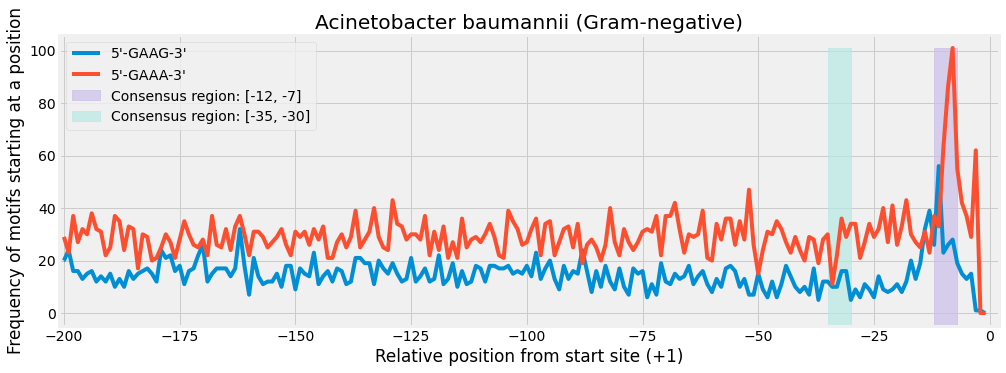

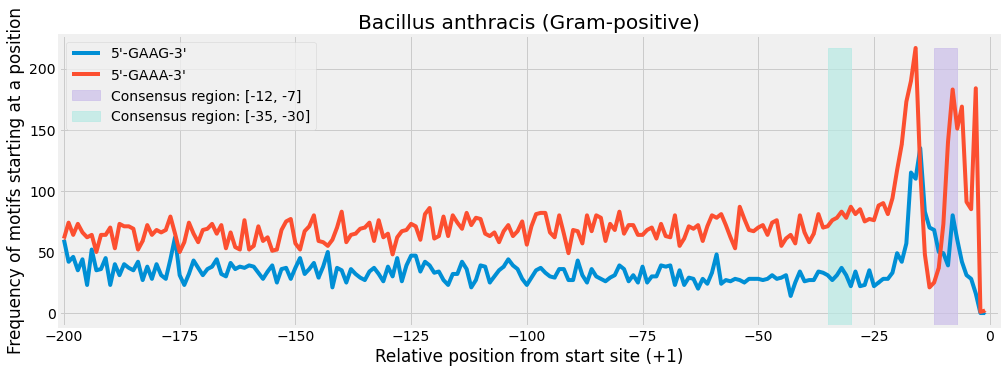

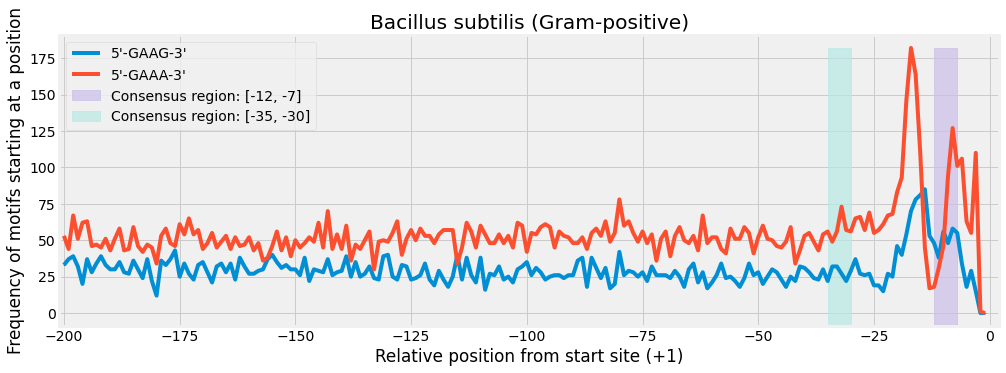

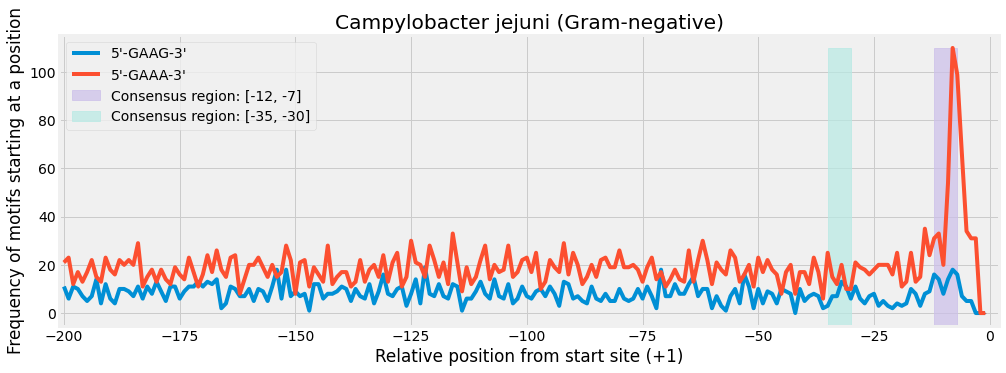

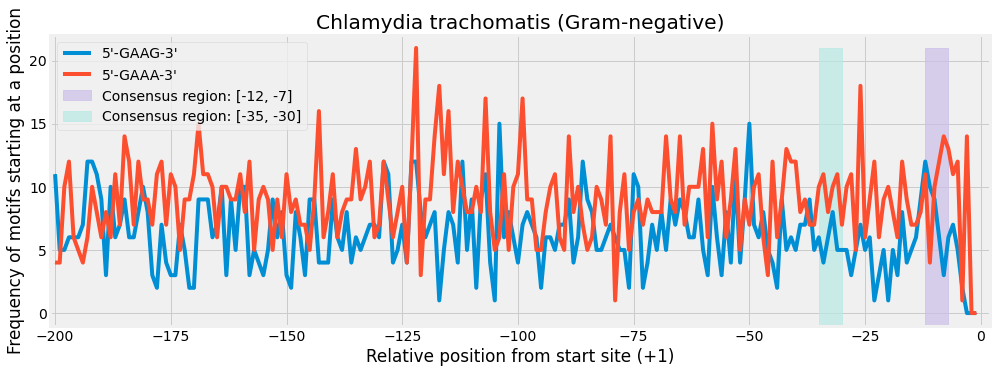

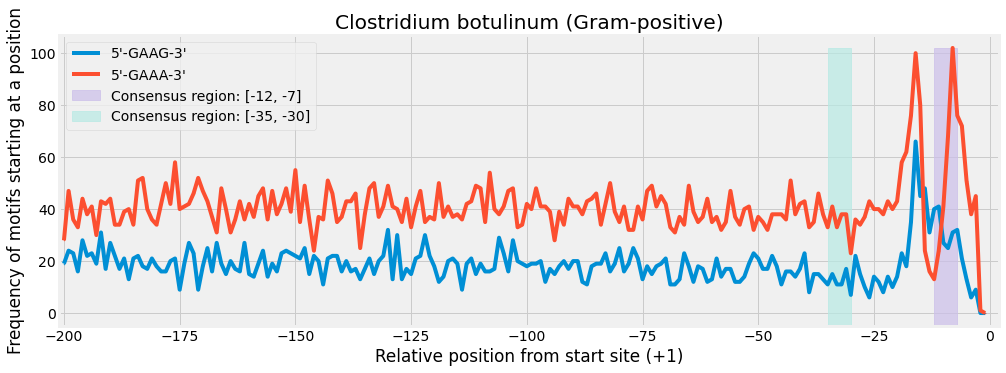

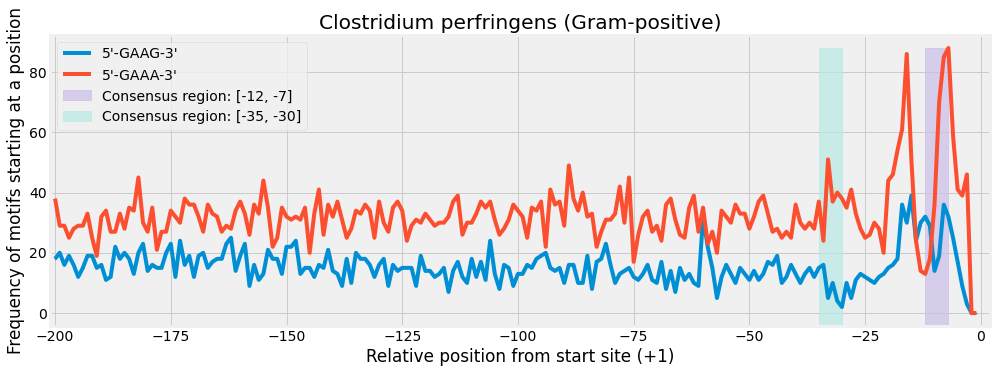

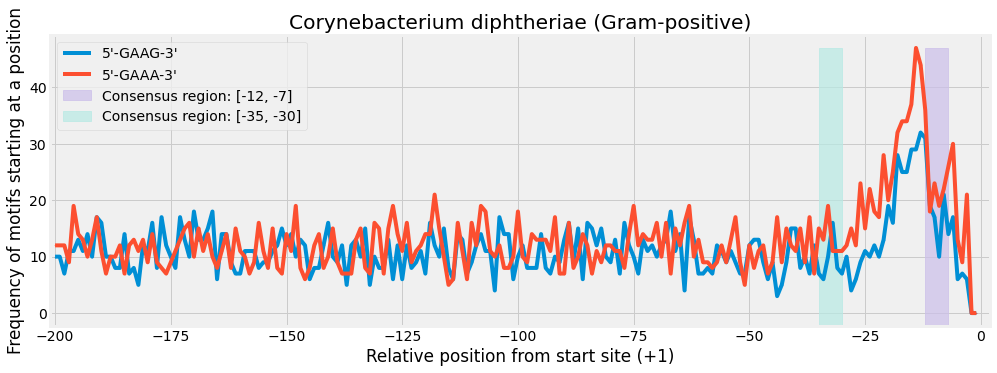

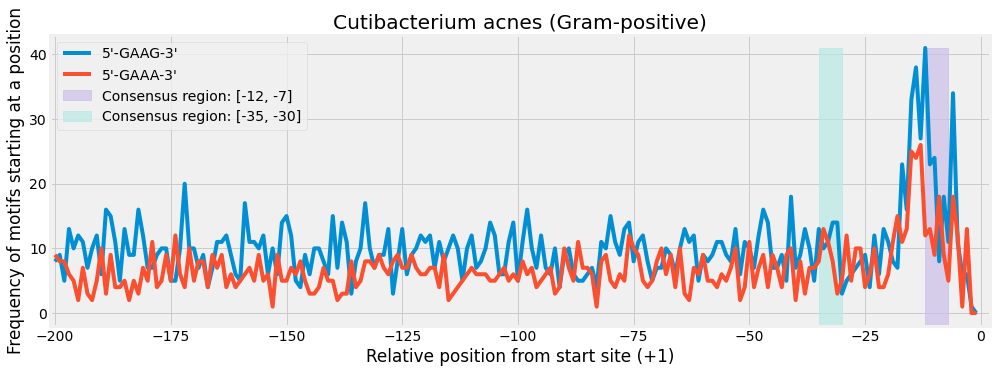

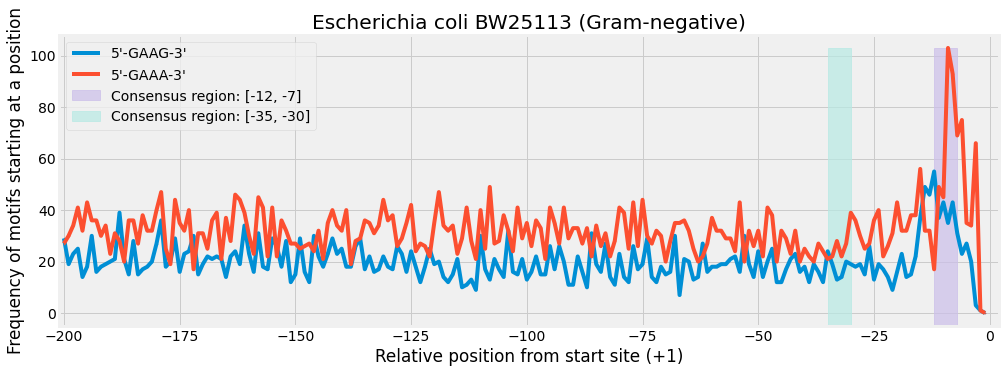

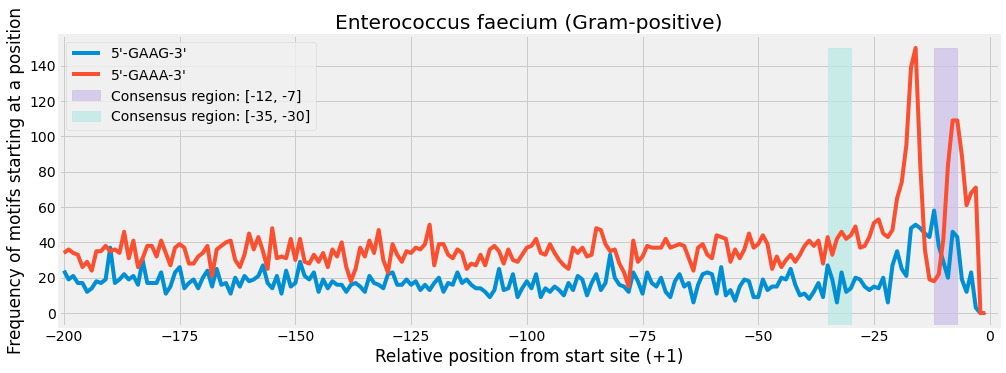

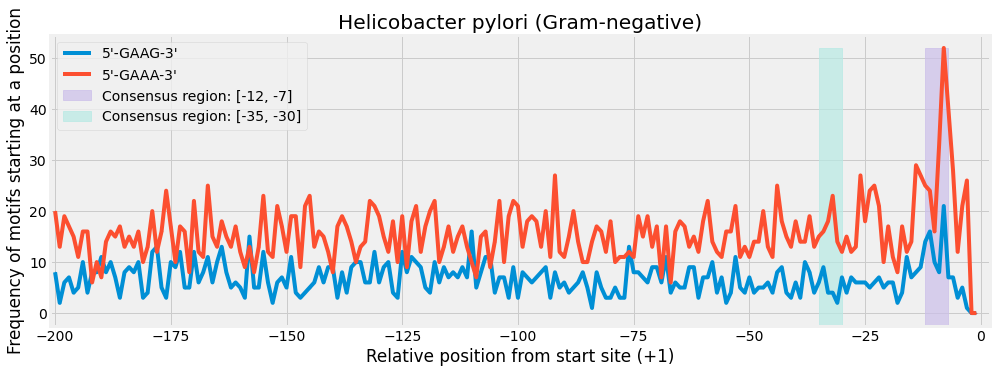

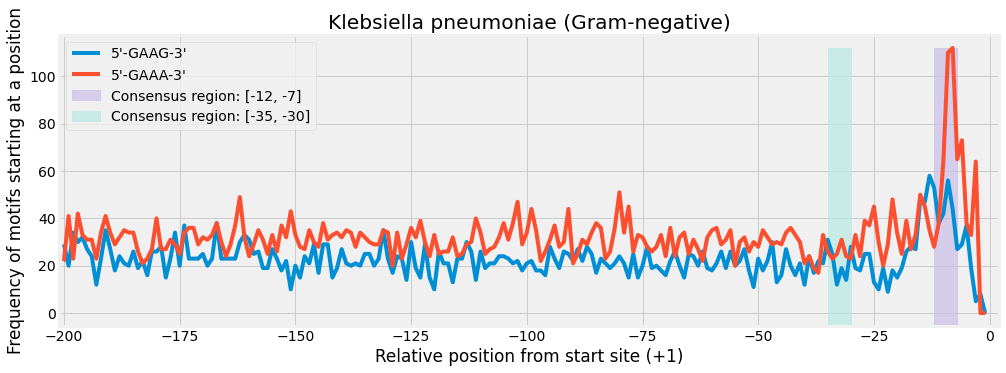

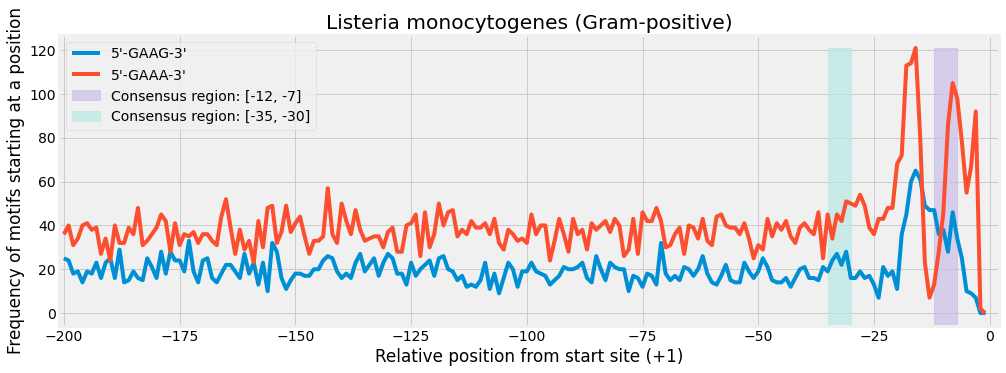

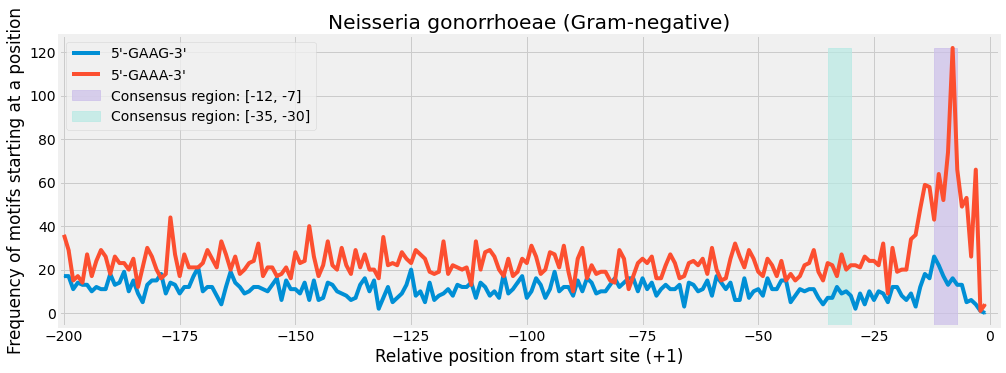

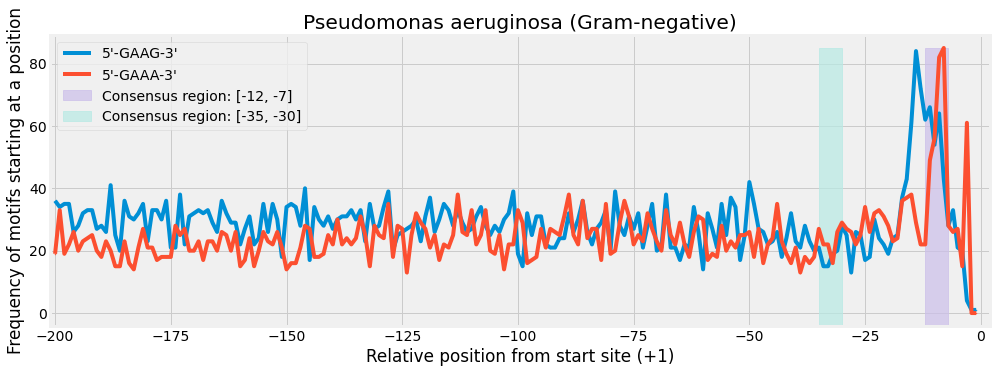

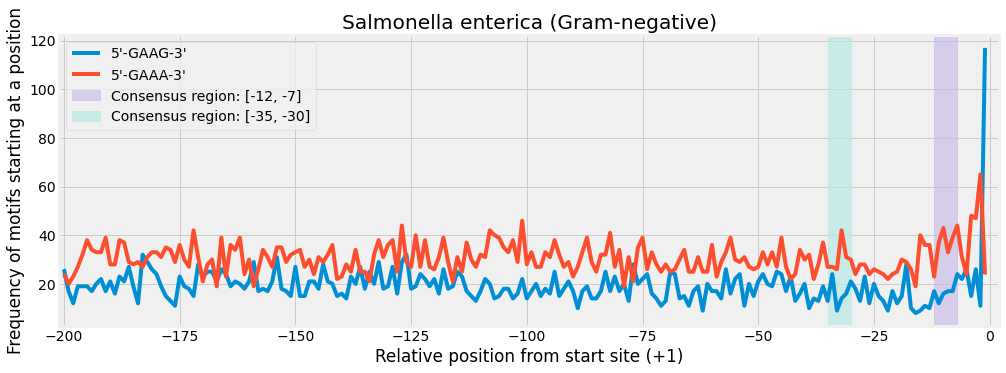

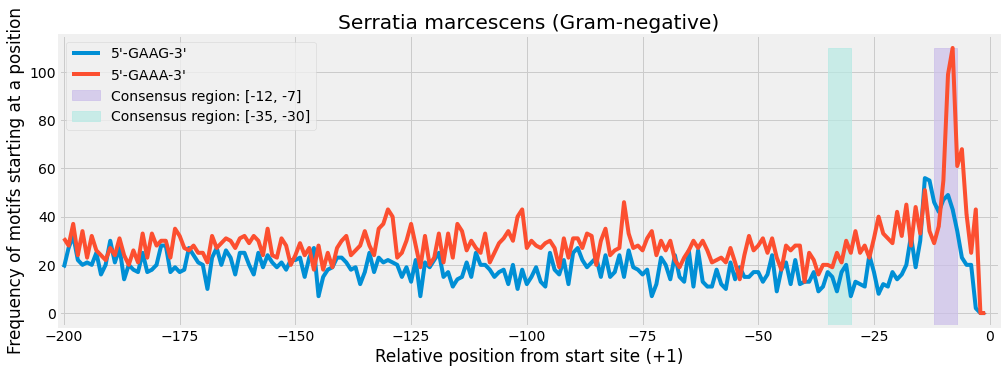

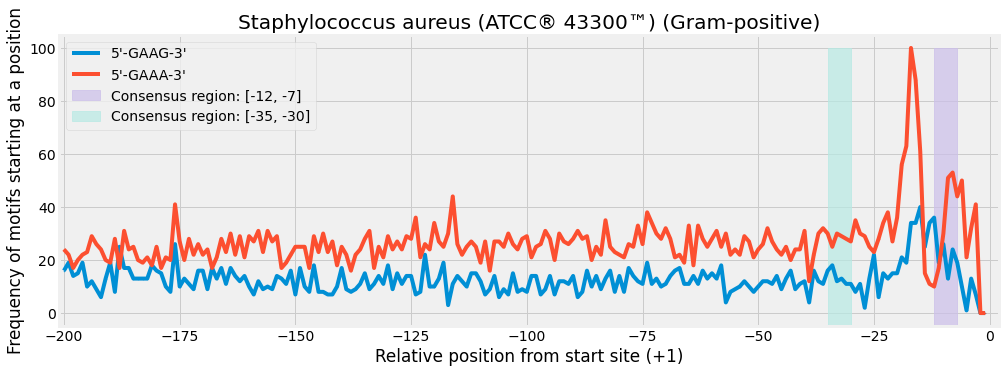

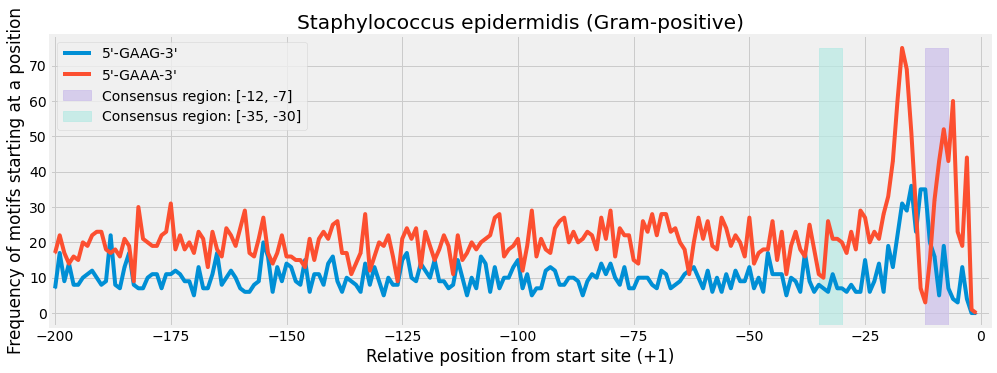

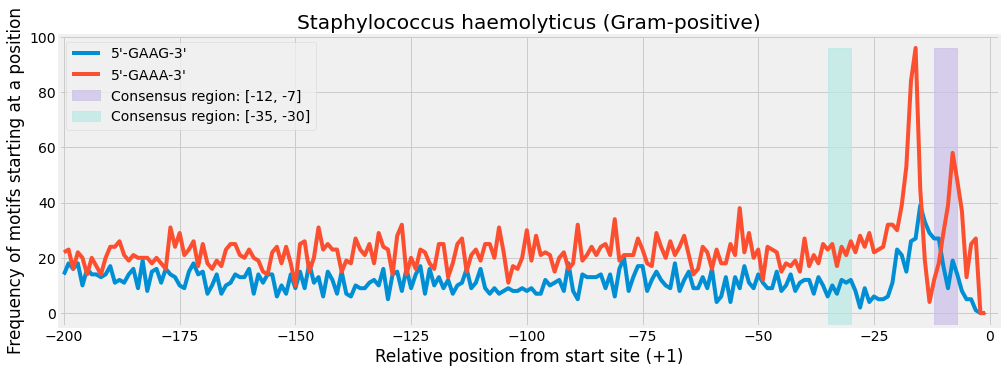

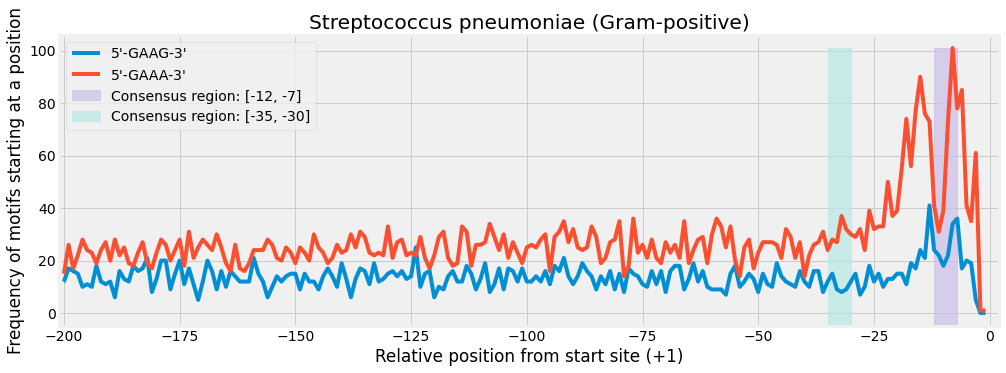

In [15]:
# Frequency plots
# -------------------------------------------------------------------------------------------------------------

for dfs_list in list_of_list_of_dfs:
    
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(15, 5), facecolor=(1, 1, 1))
    # plt.rcParams['axes.edgecolor'] = 'black'
    # plt.rcParams['axes.linewidth'] = 1
    plt.grid(True)

    plt.title(dfs_list[1].name)
    plt.xlabel('Relative position from start site (+1)')
    plt.ylabel('Frequency of motifs starting at a position')

    plt.plot(dfs_list[1].relative_pos, dfs_list[1].frequency, label="5'-GAAG-3'", 
             marker='o', markersize=0.5)
    plt.plot(dfs_list[0].relative_pos, dfs_list[0].frequency,label="5'-GAAA-3'", 
             marker='o', markersize=0.5)

    min_val, max_val = plt.gca().get_ylim()

    # Consensus regions (colors- peach: #F6C9BC, purple: #CCBFE9, skyblue: #B8E9E4)
    consensus_region_1 = mpatches.Rectangle((-12, min_val), 5, max_val, fill=True,
                                  color="#CCBFE9", alpha=0.7, linewidth=1, label='Consensus region: [-12, -7]')
    plt.gca().add_patch(consensus_region_1)

    consensus_region_2 = mpatches.Rectangle((-35, min_val), 5, max_val, fill=True,
                                  color="#B8E9E4", alpha=0.7, linewidth=1, label='Consensus region: [-35, -30]')
    plt.gca().add_patch(consensus_region_2)

    plt.xlim(-201, +2)
    plt.legend(loc = 'best')
    # fig.savefig('whatever.png', facecolor=fig.get_facecolor(), edgecolor='none')
    # https://stackoverflow.com/questions/4804005/matplotlib-figure-facecolor-background-color
    plt.savefig(f'./plots/{dfs_list[1].name}.png', 
                facecolor=(1,1,1), 
                dpi=500, bbox_inches='tight')

#### Division by summed value normalization: MA_sum- SWAN plots

/var/folders/qw/9wxdq28x5wgcw76z273w4lp00000gn/T/ipykernel_38457/4215507962.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 5), facecolor=(1, 1, 1))


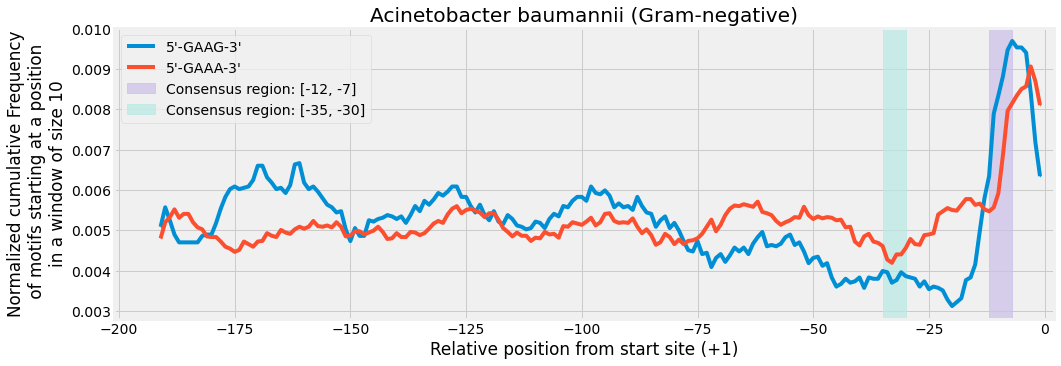

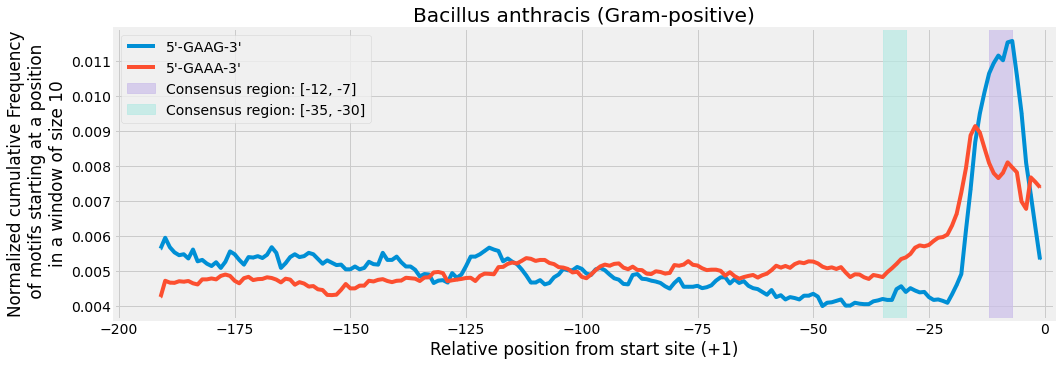

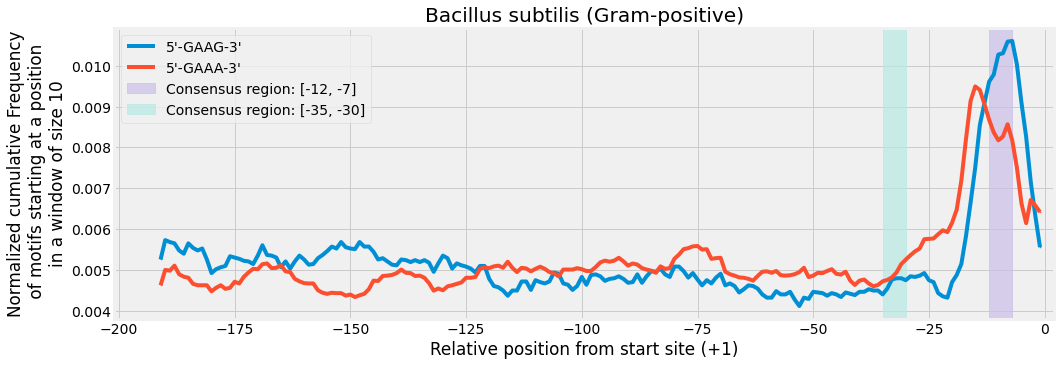

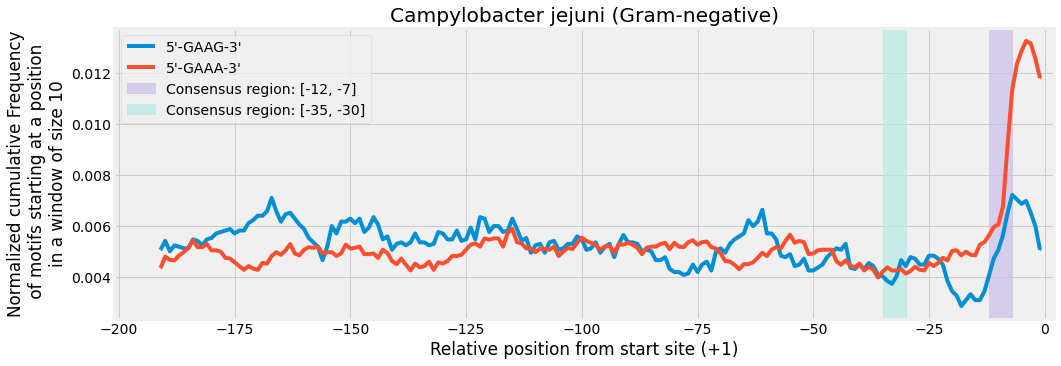

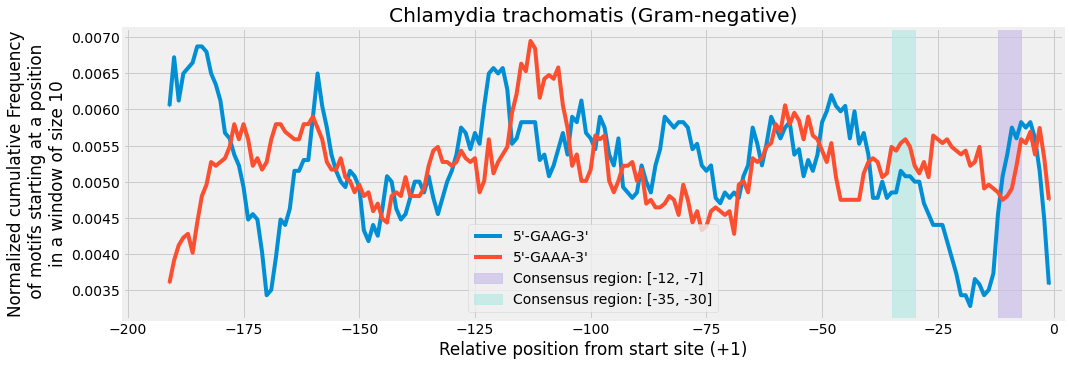

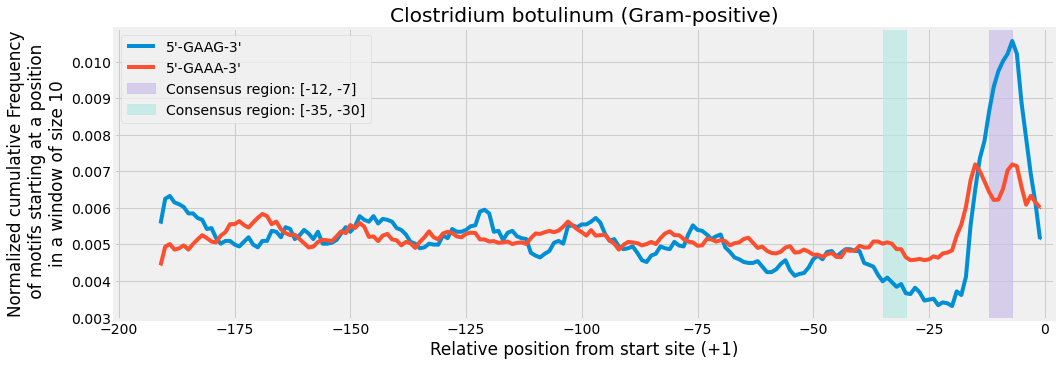

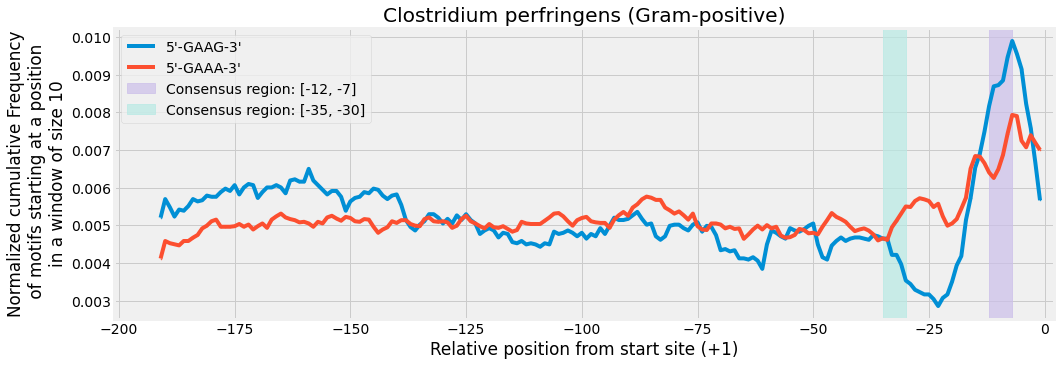

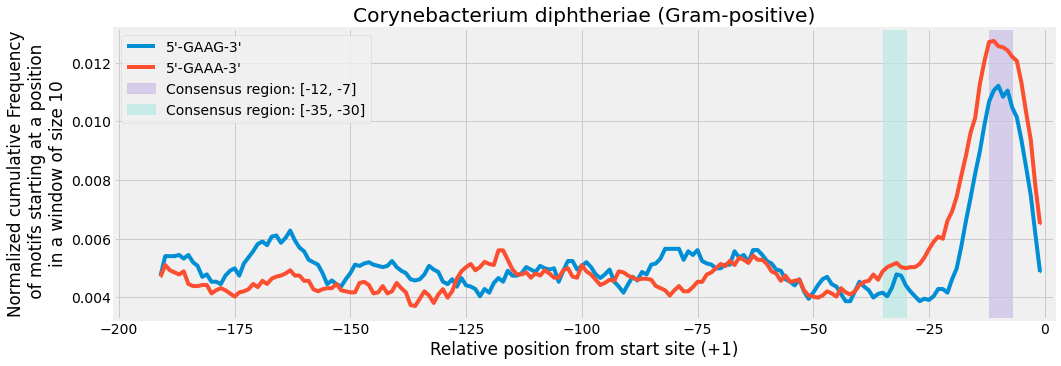

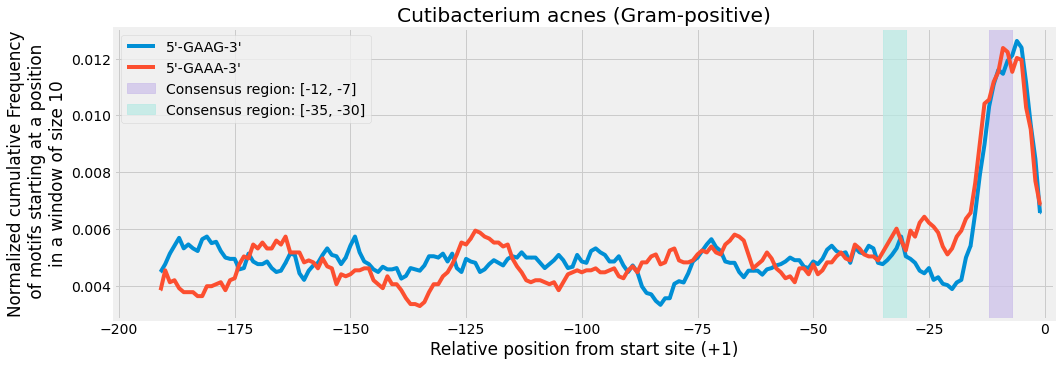

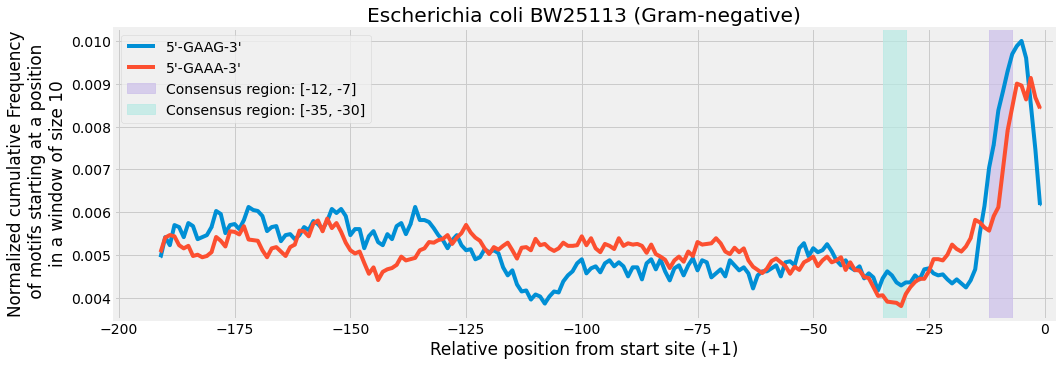

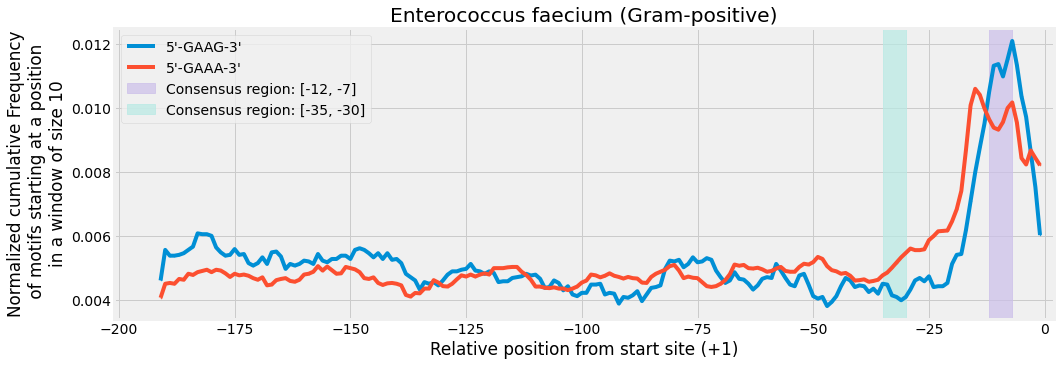

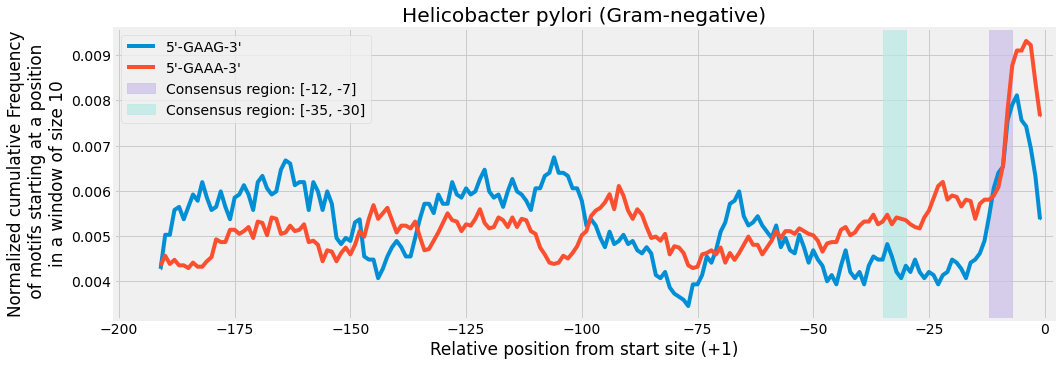

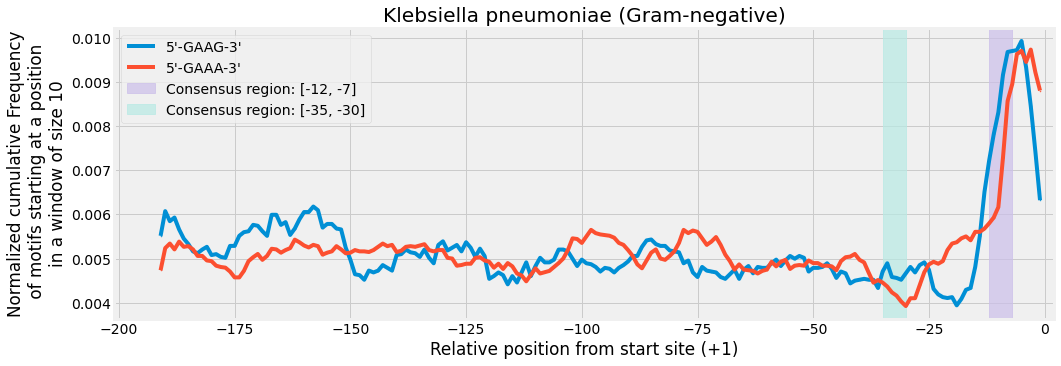

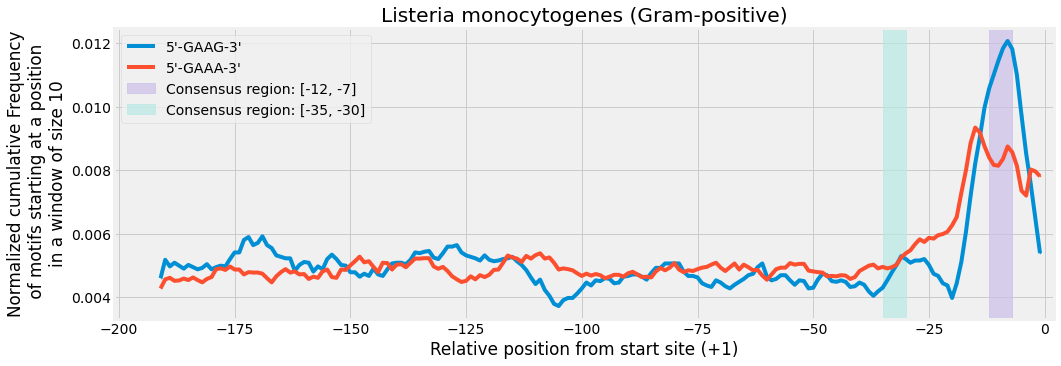

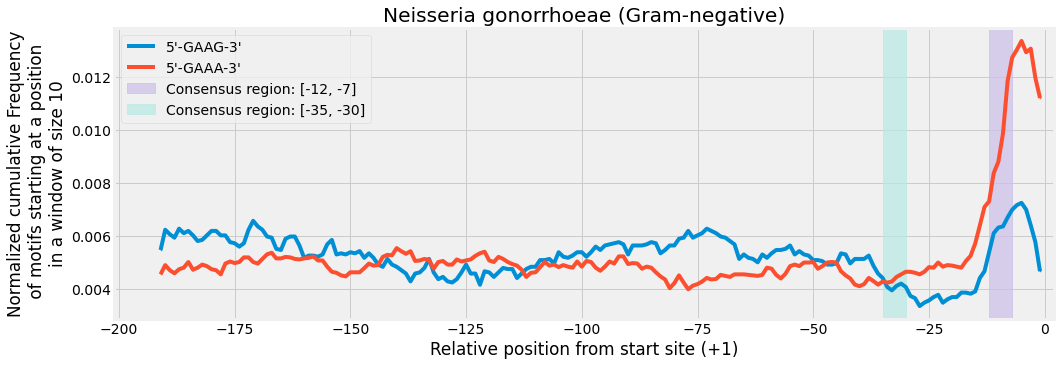

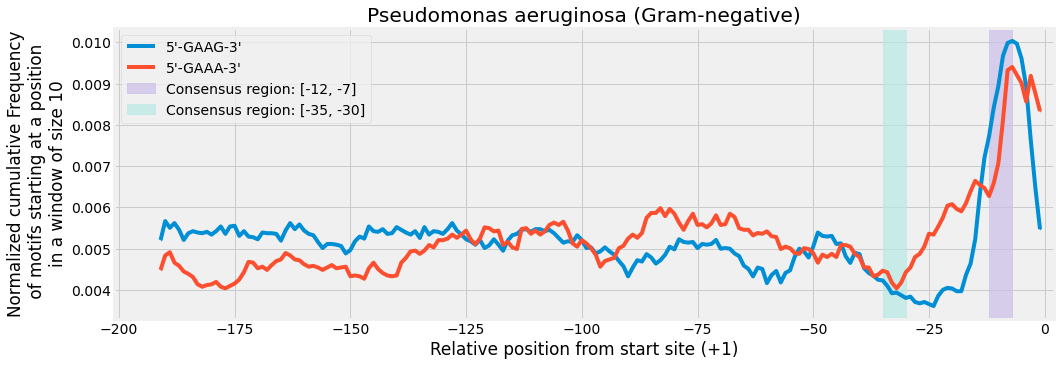

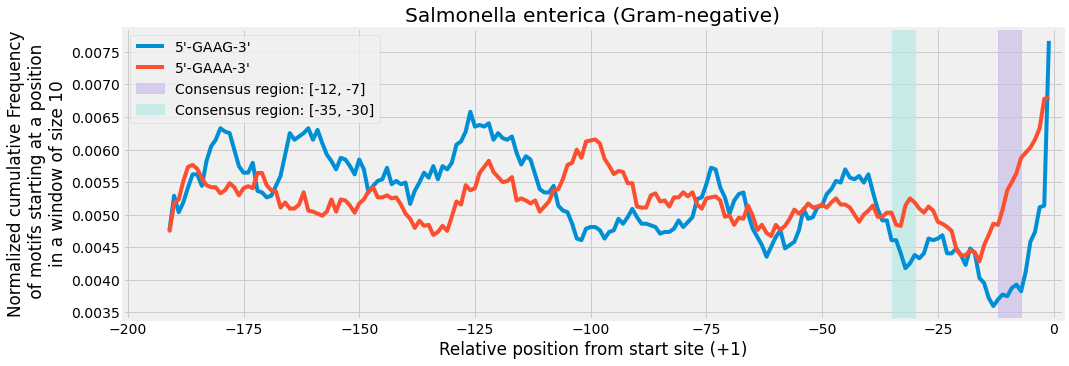

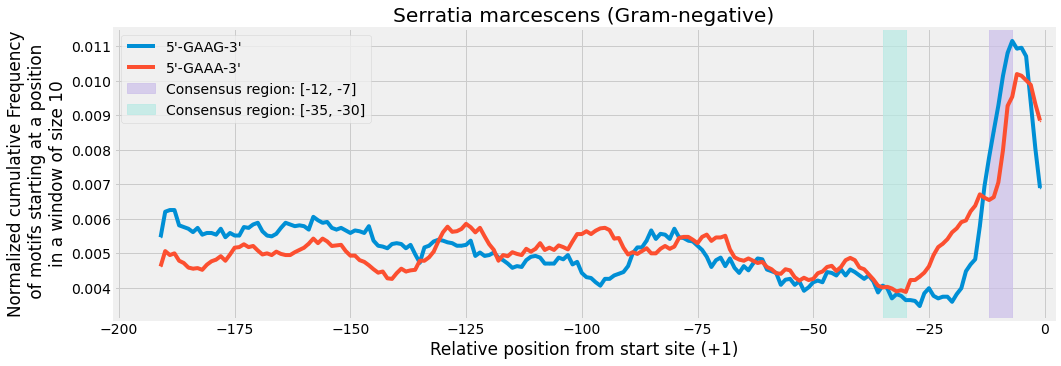

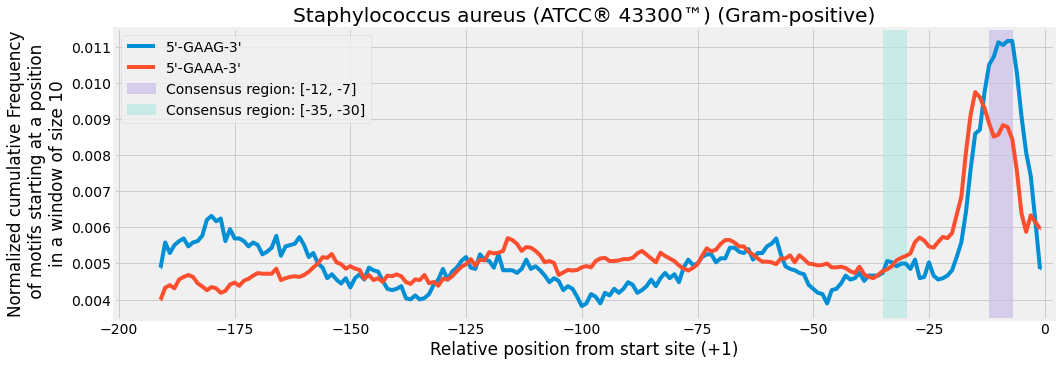

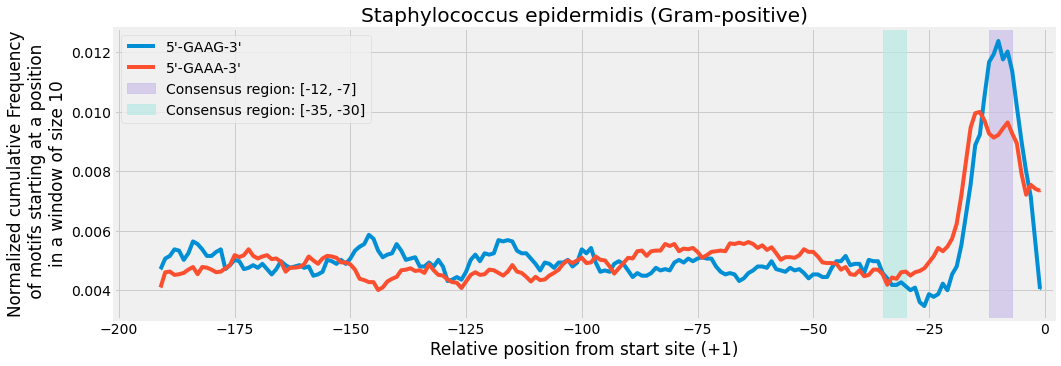

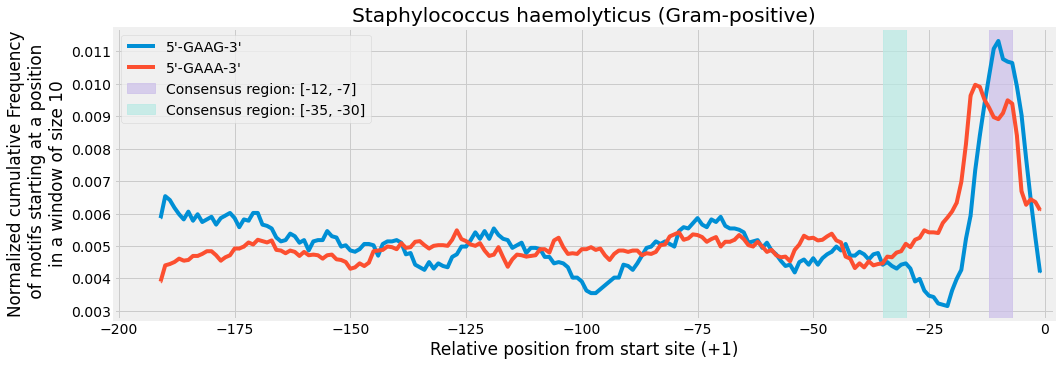

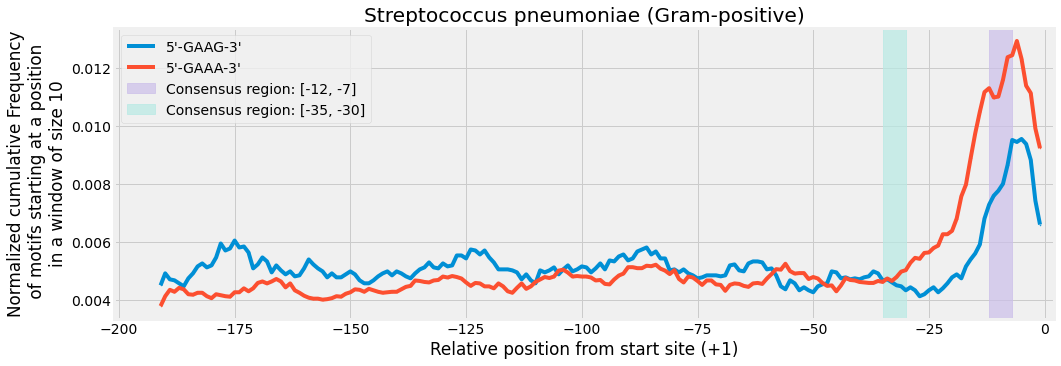

In [16]:
# Norm 2: Division by summed value normalization: MA_sum- SWAN plots
# -------------------------------------------------------------------------------------------------------------

for dfs_list in list_of_list_of_dfs:
    
    normalized_series_of_df0 = dfs_list[1].MA_sum / dfs_list[1].MA_sum.sum()
    normalized_series_of_df1 = dfs_list[0].MA_sum / dfs_list[0].MA_sum.sum()
    
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(15, 5), facecolor=(1, 1, 1))
    plt.grid(True)

    plt.title(dfs_list[1].name)
    plt.xlabel('Relative position from start site (+1)')
    plt.ylabel('Normalized cumulative Frequency\n of motifs starting at a position\nin a window of size 10')

    plt.plot(dfs_list[1].relative_pos, normalized_series_of_df0, label="5'-GAAG-3'", 
             marker='o', markersize=0.5)
    plt.plot(dfs_list[0].relative_pos, normalized_series_of_df1,label="5'-GAAA-3'", 
             marker='o', markersize=0.5)

    min_val, max_val = plt.gca().get_ylim()

    consensus_region_1 = mpatches.Rectangle((-12, min_val-1), 5, max_val+10, fill=True,
                                  color="#CCBFE9", alpha=0.7, linewidth=1, label='Consensus region: [-12, -7]')
    plt.gca().add_patch(consensus_region_1)
    consensus_region_2 = mpatches.Rectangle((-35, min_val-1), 5, max_val+10, fill=True,
                                  color="#B8E9E4", alpha=0.7, linewidth=1, label='Consensus region: [-35, -30]')
    plt.gca().add_patch(consensus_region_2)

    plt.xlim(-201, +2)
    plt.legend(loc = 'best')
#     plt.savefig(f'./plots/{dfs_list[1].name}.png', 
#                 facecolor=(1,1,1), 
#                 dpi=500, bbox_inches='tight')